In [1]:
import pandas as pd
import numpy as np
import os

In [9]:
# Read train and test datasets into pandas dataframes
train_path = './data/train.csv'
test_path = './data/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
# train_df = train_df.sample(frac = 1)
# test_df = test_df.sample(frac = 1)

In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 13.5 MB/s eta 0:00:00


In [4]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
import lightgbm as lgb

In [5]:
# Function to plot histogram of the features and targets
def plot_histplot_for_train_df(x):
   plt.figure(figsize=(5, 3))
   sns.histplot(data=train_df, x=x)
   plt.show()

In [10]:
train_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


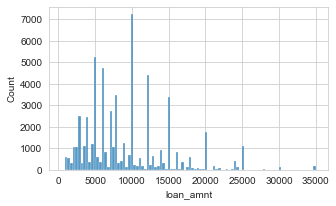

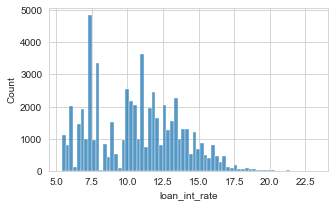

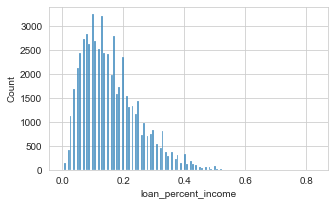

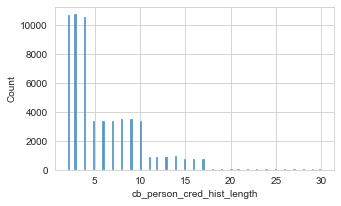

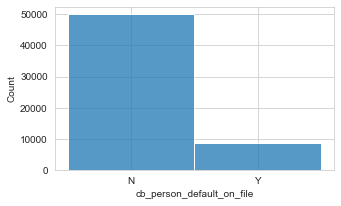

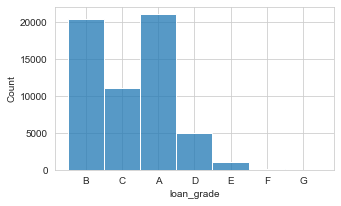

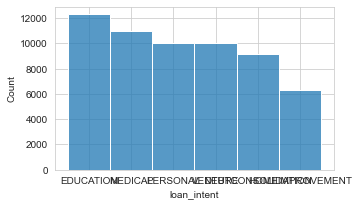

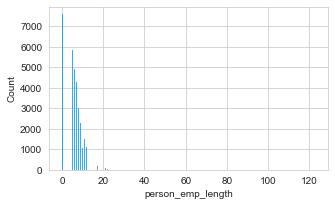

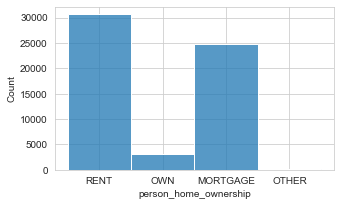

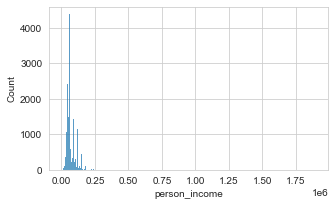

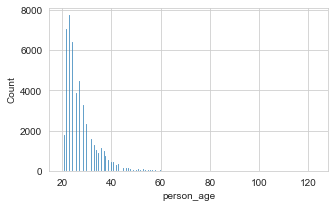

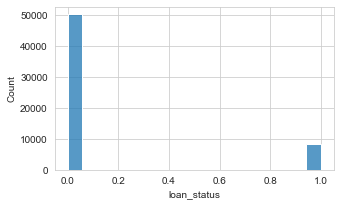

In [11]:
# plot histogram of various columns
# process the loan amount first
plot_histplot_for_train_df('loan_amnt')
plot_histplot_for_train_df('loan_int_rate')
plot_histplot_for_train_df('loan_percent_income')
plot_histplot_for_train_df('cb_person_cred_hist_length')
plot_histplot_for_train_df('cb_person_default_on_file')
plot_histplot_for_train_df('loan_grade')
plot_histplot_for_train_df('loan_intent')
plot_histplot_for_train_df('person_emp_length')
plot_histplot_for_train_df('person_home_ownership')
plot_histplot_for_train_df('person_income')
plot_histplot_for_train_df('person_age')
plot_histplot_for_train_df('loan_status')


In [12]:
# Check to see if there is missing entries
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)
pd.DataFrame(test_df.isnull().sum().sort_values(ascending=False)).head(20)


,0
cb_person_cred_hist_length,0
cb_person_default_on_file,0
loan_percent_income,0
loan_int_rate,0
loan_amnt,0
loan_grade,0
loan_intent,0
person_emp_length,0
person_home_ownership,0
person_income,0


In [13]:
# create new features
train_df['TotalInt_'] = train_df["loan_amnt"]*train_df['loan_int_rate']
train_df['Income_to_Int_'] = (train_df['person_income']*12)/(train_df["loan_amnt"]*train_df['loan_int_rate'])
train_df['Income_age_'] = train_df['person_income']/train_df["person_age"]

test_df['TotalInt_'] = test_df["loan_amnt"]*test_df['loan_int_rate']
test_df['Income_to_Int_'] = (test_df['person_income']*12)/(test_df["loan_amnt"]*test_df['loan_int_rate'])
test_df['Income_age_'] = test_df['person_income']/test_df["person_age"]


In [14]:
# Remove the outliers
train_df = train_df.loc[train_df['person_emp_length']<40]
train_df = train_df.loc[train_df['person_income']<500000]
train_df = train_df.loc[train_df['person_age']<80]

In [15]:
# List of numerical features
log_num_cols = ['person_age', 'person_income',
       'person_emp_length', 'loan_amnt','loan_int_rate', 'loan_percent_income', 'TotalInt_',
       'Income_to_Int_', 'Income_age_','cb_person_cred_hist_length']

In [16]:
# Transform the numerical columns using Sklearn pipeline.  Take the log first and then use standard scaling
from sklearn.preprocessing import FunctionTransformer

def log_transform(x):
    return np.log1p(1+x)

log_transformer = FunctionTransformer(log_transform)
numeric_transformer = Pipeline(
    steps=[("trans",log_transformer) , ("scaler", StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, log_num_cols)])
train_df[log_num_cols] = preprocessor.fit_transform(train_df)
test_df[log_num_cols] = preprocessor.fit_transform(test_df)

In [17]:
# Download category encoding libraries
!pip install category_encoders

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 82 kB 443 kB/s            
  Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)
     |████████████████████████████████| 10.1 MB 7.0 MB/s            
     |████████████████████████████████| 10.5 MB 2.4 MB/s            
     |████████████████████████████████| 35.0 MB 5.0 MB/s            
     |████████████████████████████████| 301 kB 12.3 MB/s            
     |████████████████████████████████| 53 kB 4.2 MB/s             
  Attempting uninstall: packaging
    Found existing installation: packaging 21.2
    Uninstalling packaging-21.2:
      Successfully uninstalled packaging-21.2
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [18]:
#create train and validation sets in dataframe format
X_trf = train_df.drop(['loan_status','id'], axis=1)
y_trf = train_df['loan_status']
test_id_col = test_df[['id']]
X_tef = test_df.drop(['id'], axis=1)
test_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,TotalInt_,Income_to_Int_,Income_age_
0,58645,-0.832609,0.403731,RENT,-0.205201,HOMEIMPROVEMENT,F,1.845973,1.500477,2.149931,N,-1.240302,2.225861,-1.670924,0.729692
1,58646,-0.204502,1.129433,MORTGAGE,0.582503,PERSONAL,C,0.412675,0.723447,-0.649902,Y,-0.344520,0.661718,-0.018999,1.169332
2,58647,-0.204502,-1.426541,RENT,0.358711,VENTURE,E,-1.020343,1.816411,-0.309659,Y,-1.240302,-0.182590,-0.727777,-1.292399
3,58648,1.032236,-0.304038,RENT,0.100361,DEBTCONSOLIDATION,A,-0.145190,-0.491173,-0.197309,N,0.551262,-0.318703,0.060835,-0.716135
4,58649,-0.204502,1.262656,MORTGAGE,0.956481,HOMEIMPROVEMENT,D,1.046898,1.627130,-0.085482,Y,-0.344520,1.569280,-0.782778,1.297704


In [20]:
# Try one-hot-encoding instead of target encoding
from category_encoders import OneHotEncoder
categ_cols = ['person_home_ownership','loan_intent', 'loan_grade',
       'cb_person_cred_hist_length','cb_person_default_on_file']
t_enc = OneHotEncoder(cols=categ_cols)
t_enc.fit(X_trf, y_trf)
X_trf=t_enc.transform(X_trf)
X_tef=t_enc.transform(X_tef)
X_tef.head()

,person_age,person_income,person_home_ownership_1,person_home_ownership_2,person_home_ownership_3,person_home_ownership_4,person_emp_length,loan_intent_1,loan_intent_2,loan_intent_3,...,cb_person_cred_hist_length_23,cb_person_cred_hist_length_24,cb_person_cred_hist_length_25,cb_person_cred_hist_length_26,cb_person_cred_hist_length_27,cb_person_cred_hist_length_28,cb_person_cred_hist_length_29,TotalInt_,Income_to_Int_,Income_age_
0,-0.832609,0.403731,1,0,0,0,-0.205201,0,0,0,...,0,0,0,0,0,0,0,2.225861,-1.670924,0.729692
1,-0.204502,1.129433,0,0,1,0,0.582503,0,0,1,...,0,0,0,0,0,0,0,0.661718,-0.018999,1.169332
2,-0.204502,-1.426541,1,0,0,0,0.358711,0,0,0,...,0,0,0,0,0,0,0,-0.182590,-0.727777,-1.292399
3,1.032236,-0.304038,1,0,0,0,0.100361,0,0,0,...,0,0,0,0,0,0,0,-0.318703,0.060835,-0.716135
4,-0.204502,1.262656,0,0,1,0,0.956481,0,0,0,...,0,0,0,0,0,0,0,1.569280,-0.782778,1.297704


In [21]:
# Split the dataset into test and validation sets
X_tr,X_va,y_tr,y_va = train_test_split(X_trf,y_trf,test_size = 0.3, shuffle=True,random_state = 23,stratify=y_trf)
print(type(X_tr))

<class 'pandas.core.frame.DataFrame'>


In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader, SubsetRandomSampler,Dataset,Subset
from torchmetrics import AUROC


In [24]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

Xt = torch.tensor(X_tr.values,dtype=torch.float32)
yt = torch.tensor(y_tr.values,dtype=torch.float32).reshape(-1,1)

t_dataset = CustomDataset(Xt,yt)
t_dataloader = DataLoader(t_dataset, batch_size=32, shuffle=False)

Xv = torch.tensor(X_va.values,dtype=torch.float32)
yv = torch.tensor(y_va.values,dtype=torch.float32).reshape(-1,1)

v_dataset = CustomDataset(Xv,yv)
v_dataloader = DataLoader(v_dataset, batch_size=32, shuffle=False)

Xtest = torch.tensor(X_tef.values,dtype=torch.float32)

In [25]:
model = nn.Sequential(
    nn.Linear(X_tr.shape[1], 40),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(10, 1),
    nn.Sigmoid())
print(model)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Sequential(
  (0): Linear(in_features=57, out_features=40, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=40, out_features=20, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=20, out_features=10, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=10, out_features=1, bias=True)
  (10): Sigmoid()
)


Finished epoch 0, latest training loss 0.334068238735199
latest validation loss 0.2382361888885498
Finished epoch 1, latest training loss 0.34814170002937317
latest validation loss 0.22291377186775208
Finished epoch 2, latest training loss 0.31563249230384827
latest validation loss 0.2053418904542923
Finished epoch 3, latest training loss 0.3251212239265442
latest validation loss 0.19017860293388367
Finished epoch 4, latest training loss 0.3431396484375
latest validation loss 0.1705491989850998
Finished epoch 5, latest training loss 0.37881332635879517
latest validation loss 0.1556241512298584
Finished epoch 6, latest training loss 0.34067651629447937
latest validation loss 0.1485372632741928
Finished epoch 7, latest training loss 0.38655123114585876
latest validation loss 0.14350555837154388
Finished epoch 8, latest training loss 0.34587445855140686
latest validation loss 0.141627699136734
Finished epoch 9, latest training loss 0.39004793763160706
latest validation loss 0.137749910354

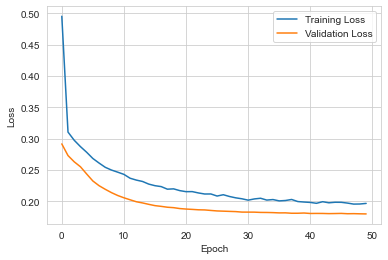

/Users/algh/Library/Python/3.6/lib/python/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


ValueError: The `target` has to be an integer tensor.

In [26]:
# Number of epochs
num_epochs = 50
t_losses = []
v_losses = []
for epoch in range(num_epochs):
    # Training loop
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(t_dataloader):
        # Train your model on the batch
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Finished epoch {epoch}, latest training loss {loss.item()}')
    t_losses.append(epoch_loss/len(t_dataloader))

    # Validation loop
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for data, target in v_dataloader:
            # Evaluate your model on the validation set
            output = model(data)
            loss = loss_fn(output,target)
            # ... calculate validation metrics
            epoch_loss += loss.item()
    print(f'latest validation loss {loss.item()}')
    v_losses.append(epoch_loss/len(v_dataloader))

# Plot the learning curves
plt.plot(t_losses, label='Training Loss')
plt.plot(v_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate ROC AUC
auroc = AUROC(task="binary")
auroc_value = auroc(output,target)
print(f'The ROC AUC is {auroc_value}')

In [27]:
# prepare the final prediction output for submission
model.eval()
y_final = model(Xtest)
y_final_np = y_final.detach().numpy()
df = pd.DataFrame(y_final_np,dtype=float,columns=['loan_status'])
test_id_col = test_id_col.sort_values(by='id')
final = pd.concat([test_id_col,df],axis=1)
final.to_csv('submission.csv', index=False)